# Insurance Charges Prediction

This project explores the factors affecting insurance charges and builds a predictive model using regression techniques.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Data Understanding

## Data Dictionary

| Column   | Description                    |
| -------- | ------------------------------ |
| `Age`      | Age of the customer            |
| `Sex`      | Biological sex of the customer |
| `BMI`      | Body Mass Index                |
| `Children` | Number of children             |
| `Smoker`   | Smoker status (yes/no)         |
| `Region`   | Customer's region              |
| `Charges`  | Annual insurance charges       |

## Initial Observations

In [2]:
# Reading the CSV file
df = pd.read_csv('insurance.csv')

# High-level understanding of the dataset
print(df.head())
print()
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


## Univariate Analysis

### Univariate Statistics

#### Numeric Variables

In [3]:
numeric_description = df.describe().T.round(2) # tranposed

# adding data types, unique, missing, missing % values
numeric_description.insert(1, 'type', df.dtypes)
numeric_description.insert(2, 'missing', df.isna().sum())
numeric_description.insert(3, 'missing %', round(df.isna().sum() / len(df), 2))
numeric_description.insert(4, 'unique', df.nunique())

# adding skewness & kurtosis
numeric_variables = df.select_dtypes(['float','int'])
numeric_description['skew'] = numeric_variables.skew().round(2)
numeric_description['kurt'] = numeric_variables.kurt().round(2)

numeric_description

,count,type,missing,missing %,unique,mean,std,min,25%,50%,75%,max,skew,kurt
age,1338.0,int64,0,0.0,47,39.21,14.05,18.00,27.00,39.00,51.00,64.00,0.06,-1.25
bmi,1338.0,float64,0,0.0,548,30.66,6.10,15.96,26.30,30.40,34.69,53.13,0.28,-0.05
children,1338.0,int64,0,0.0,6,1.09,1.21,0.00,0.00,1.00,2.00,5.00,0.94,0.20
charges,1338.0,float64,0,0.0,1337,13270.42,12110.01,1121.87,4740.29,9382.03,16639.91,63770.43,1.52,1.61


#### Categorical Variables

In [4]:
categorical_description = df.select_dtypes(['object']).describe(include='all').T

# adding type, missing, missing %
categorical_description.insert(1, 'type', df.dtypes)
categorical_description.insert(2, 'missing', df.isna().sum())
categorical_description.insert(3, 'missing %', round(df.isna().sum() / len(df), 2))

categorical_description

,count,type,missing,missing %,unique,top,freq
sex,1338,object,0,0.0,2,male,676
smoker,1338,object,0,0.0,2,no,1064
region,1338,object,0,0.0,4,southeast,364


### Univariate Visualizations

#### Numeric Variables

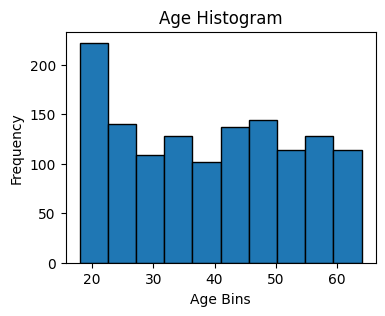

In [5]:
df['age'].plot.hist(bins=10,
                    edgecolor='black',
                    xlabel='Age Bins',
                    title='Age Histogram',
                    figsize=(4,3))
plt.show()

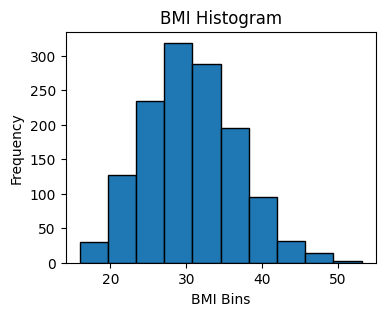

In [6]:
df['bmi'].plot.hist(bins=10,
                    edgecolor='black',
                    xlabel='BMI Bins',
                    title='BMI Histogram',
                    figsize=(4,3))
plt.show()

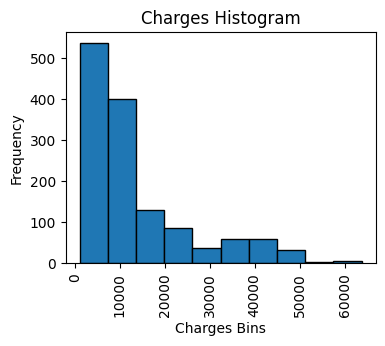

In [7]:
df['charges'].plot.hist(bins=10,
                        edgecolor='black',
                        xlabel='Charges Bins',
                        title='Charges Histogram',
                        figsize=(4,3))
plt.xticks(rotation=90)
plt.show()

**Note:** For discrete variables, bar charts provide clearer insights than histograms.

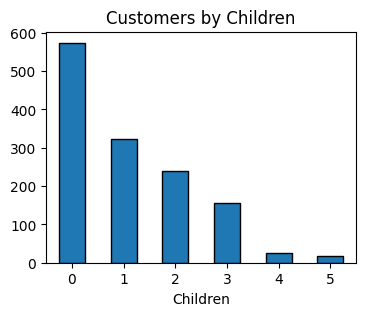

In [8]:
df['children'].value_counts().plot.bar(edgecolor='black',
                         xlabel='Children',
                         title='Customers by Children',
                         figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

#### Categorical Variables

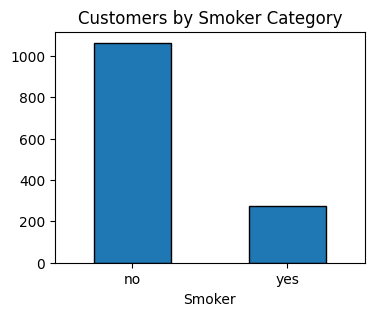

In [9]:
df['smoker'].value_counts().plot.bar(edgecolor='black',
                         xlabel='Smoker',
                         title='Customers by Smoker Category',
                         figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

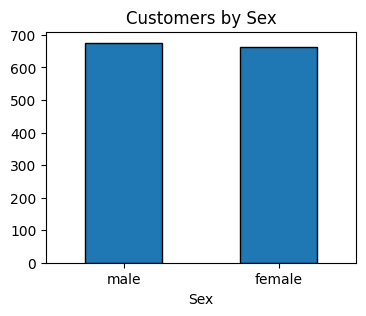

In [10]:
df['sex'].value_counts().plot.bar(edgecolor='black',
                         xlabel='Sex',
                         title='Customers by Sex',
                         figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

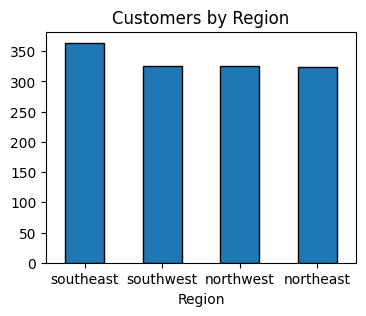

In [11]:
df['region'].value_counts().plot.bar(edgecolor='black',
                         xlabel='Region',
                         title='Customers by Region',
                         figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

### Observations

1. `Age`:
    * Distribution roughly uniform across adulthood (18–64).
    * Slight positive skew but generally balanced.
2. `BMI`:
    * Mean ~30.7 (borderline obese).
    * Distribution fairly normal, small right skew, with some high outliers (>45).
3. `Children`:
    * Most customers have 0–2 children; few with >3.
    * Right skewed.
4. `Charges`:
    * Highly right-skewed; mean ~$13k but maximum ~$64k.
    * Outliers present, especially for non-smokers.
5. `Sex`: ~50/50 split (slightly more males).
6. `Smoker`: Majority non-smokers (~80%).
7. `Region`: Fairly balanced, but Southeast most frequent (~27%).

## Bivariate Analysis

### Bivariate Statistics

##### Numeric-to-Numeric Relationships

In [12]:
# correlation matrix
correlation_matrix = df[['age', 'bmi', 'charges', 'children']].corr(method='pearson').round(3)
print(f'Correlation Matrix:\n{correlation_matrix}\n')

# one-on-one relationships
corr, pvalue = stats.pearsonr(df['age'], df['charges'])
print(f'Age & Charges:\nPearson Correlation = {corr:.3f}, P-value = {pvalue:.3f}')
corr, pvalue = stats.pearsonr(df['bmi'], df['charges'])
print(f'BMI & Charges:\nPearson Correlation = {corr:.3f}, P-value = {pvalue:.3f}')
corr, pvalue = stats.pearsonr(df['children'], df['charges'])
print(f'Children & Charges:\nPearson Correlation = {corr:.3f}, P-value = {pvalue:.3f}')

Correlation Matrix:
            age    bmi  charges  children
age       1.000  0.109    0.299     0.042
bmi       0.109  1.000    0.198     0.013
charges   0.299  0.198    1.000     0.068
children  0.042  0.013    0.068     1.000

Age & Charges:
Pearson Correlation = 0.299, P-value = 0.000
BMI & Charges:
Pearson Correlation = 0.198, P-value = 0.000
Children & Charges:
Pearson Correlation = 0.068, P-value = 0.013


##### Categorical-to-Numeric Relationships

In [13]:
# Smoker - Charges
tstat, pvalue = stats.ttest_ind(df[df['smoker'] == 'yes']['charges'],
                                df[df['smoker'] == 'no']['charges'],
                                equal_var='False') # Welch's test assumes heteroscedasticity
print(f'Smoker & Charges:\nT-Stat = {tstat:.3f}, P-value = {pvalue:.3f}')

# Sex - Charges
tstat, pvalue = stats.ttest_ind(df[df['sex'] == 'male']['charges'],
                                df[df['sex'] == 'female']['charges'],
                                equal_var='False')
print(f'Sex & Charges:\nT-Stat = {tstat:.3f}, P-value = {pvalue:.3f}')

# Region - Charges
region_groups = [df[df['region'] == k]['charges'] for k in df['region'].unique()]
fstat, pvalue = stats.f_oneway(*region_groups)
print(f'Region & Charges:\nF-Stat = {fstat:.3f}, P-value = {pvalue:.3f}')

# Children - Charges
children_groups = [df[df['children'] == k]['charges'] for k in df['children'].unique()]
fstat, pvalue = stats.f_oneway(*children_groups)
print(f'Children & Charges:\nF-Stat = {fstat:.3f}, P-value = {pvalue:.3f}')

Smoker & Charges:
T-Stat = 46.665, P-value = 0.000
Sex & Charges:
T-Stat = 2.098, P-value = 0.036
Region & Charges:
F-Stat = 2.970, P-value = 0.031
Children & Charges:
F-Stat = 3.297, P-value = 0.006


### Bivariate Visualizations

##### Numeric-to-Numeric Relationships

In [14]:
print('Age & Charges')
print()
x = df['age']
y = df['charges']

# 1. Linear
slope, intercept = np.polyfit(x, y, 1)
y_linear = intercept + slope * x

# 2. Polynomial (degree 2)
coeffs2 = np.polyfit(x, y, 2)
y_poly2 = np.polyval(coeffs2, x)

# 3. Polynomial (degree 3)
coeffs3 = np.polyfit(x, y, 3)
y_poly3 = np.polyval(coeffs3, x)

# 4. Logarithmic: y = a*ln(x) + b
log_x = np.log(x)
slope_log, intercept_log = np.polyfit(log_x, y, 1)
y_log = intercept_log + slope_log * log_x

# 5. Exponential: y = a * e^(b*x)
# take log(y) to linearize
log_y = np.log(y)
slope_exp, intercept_exp = np.polyfit(x, log_y, 1)
y_exp = np.exp(intercept_exp + slope_exp * x)

# 6. Power: log(y)=log(a)+b*log(x)
# Log-transform both variables
log_x = np.log(x)
log_y = np.log(y)
b, log_a = np.polyfit(log_x, log_y, 1)

# Convert back to original scale
a = np.exp(log_a)
y_power = a * x**b

# Compare R²
print("R² scores:")
print(f'Linear: {round(r2_score(y, y_linear),3)}')
print(f'Poly2: {round(r2_score(y, y_poly2),3)}')
print(f'Poly3: {round(r2_score(y, y_poly3),3)}')
print(f'Log: {round(r2_score(y, y_log),3)}')
print(f'Exponential: {round(r2_score(y, y_exp),3)}')
print(f'Power: {round(r2_score(y, y_power),3)}')

Age & Charges

R² scores:
Linear: 0.089
Poly2: 0.091
Poly3: 0.091
Log: 0.084
Exponential: 0.009
Power: 0.013


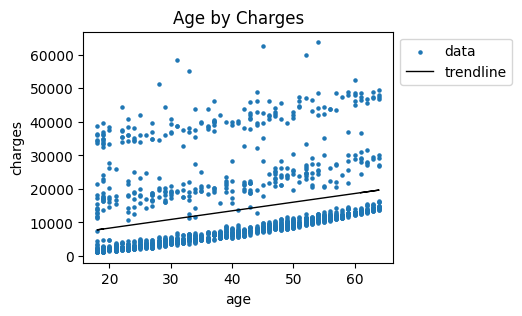

In [15]:
df.plot.scatter(x='age',
                y='charges',
                marker='.',
                title='Age by Charges',
                figsize=(4,3),
                label='data')
plt.plot(df['age'], y_linear, color='black', linewidth=1, label='trendline')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

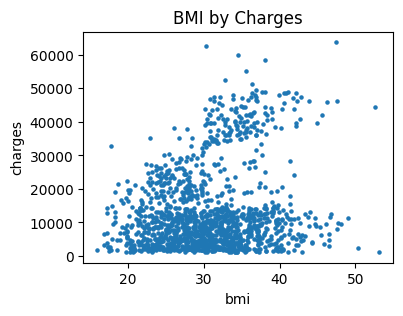

In [16]:
df.plot.scatter(x='bmi',
                y='charges',
                marker='.',
                title='BMI by Charges',
                figsize=(4,3))
plt.show()

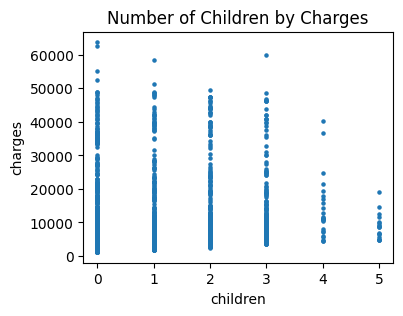

In [17]:
df.plot.scatter(x='children',
                y='charges',
                marker='.',
                title='Number of Children by Charges',
                figsize=(4,3))
plt.show()

##### Categorical-to-Numeric Relationships

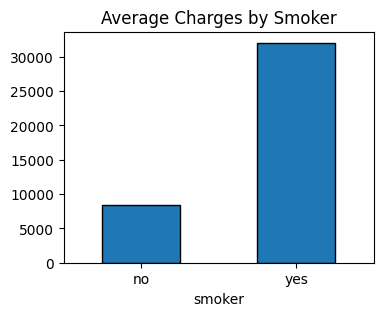

In [18]:
df.groupby('smoker')['charges'].mean().plot.bar(title='Average Charges by Smoker',
                                                edgecolor='black',
                                                figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

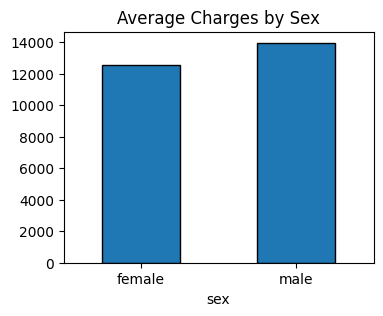

In [19]:
df.groupby('sex')['charges'].mean().plot.bar(title='Average Charges by Sex',
                                                edgecolor='black',
                                                figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

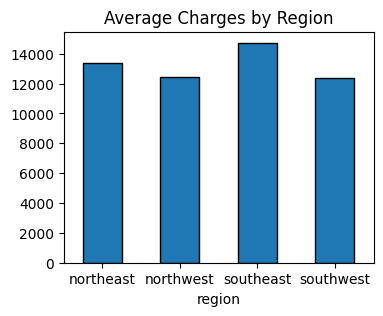

In [20]:
df.groupby('region')['charges'].mean().plot.bar(title='Average Charges by Region',
                                                edgecolor='black',
                                                figsize=(4,3))
plt.xticks(rotation=0)
plt.show()

### Observations

1. **Correlation Heatmap**: Charges strongly correlated with smoker status, moderately with age and BMI.
2. `Age` vs `Charges`: No strong linear correlation overall, but charges rise sharply for older people.
3. `BMI` vs `Charges`: Charges increase with BMI for customer.
4. `Children` vs `Charges`: Weak relationship; slight increase with more children, but not significant.
5. `Sex` vs `Charges`: No strong difference between male/female overall.
6. `Smoker` vs `Charges`: Very strong effect: smokers’ charges are several times higher than non-smokers. Key predictive feature.
7. `Region` vs `Charges`: Small differences; region is not a strong driver.

## Multivariate Analysis

### Group Confounding

In [21]:
# Smokers by Age & BMI
df.groupby('smoker')[['age','bmi']].agg(['mean','count']).reset_index()

smoker        age              bmi      
               mean count       mean count
0     no  39.385338  1064  30.651795  1064
1    yes  38.514599   274  30.708449   274

### Observations
* `Age`: Mean difference = 39.39 − 38.51 ≈ 0.88 years → very small.
* `BMI`: Mean difference = 30.71 − 30.65 ≈ 0.06 → negligible.
* From these numbers, age and BMI don’t differ much between smokers and non-smokers — so they are not likely strong confounders here.

# Data Preparation

## Duplicate Data Handling

In [22]:
# checking duplicate records
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


### Observations
* Identified one duplicate record in the dataset.
* Dataset doesn’t have a unique identifier (like id), so can’t be sure a duplicate row is truly the same person — it might just be two different people with identical features.
* The impact on analysis is minimal, and removal is not necessary.

## Missing Data Handling

In [23]:
# checking missing data by columns
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Observations
No missing data

## Feature Engineering

### Math Transformations

The `charges` variable is right-skewed and contains outliers. To address this, will apply log transformations to normalize its distribution and reduce the impact of extreme values.

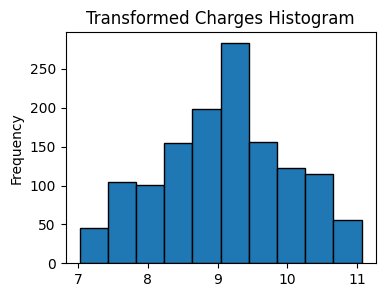

In [24]:
df['charges_log'] = np.log(df['charges']) # log transformation

df['charges_log'].plot.hist(edgecolor='black',
                            title='Transformed Charges Histogram',
                            figsize=(4,3))
plt.show()

### Encoding

In [25]:
# Binary encoding for variables with 2 groups
df['smoker_binary'] = df['smoker'].map({'no' : 0, 'yes' : 1})
df['sex_binary'] = df['sex'].map({'female' : 0, 'male' : 1})

# One-hot encoding for variables with 3+ groups
region_dummies = pd.get_dummies(df['region'],
               drop_first=True)
df = pd.concat([df, region_dummies], axis=1)

## Outlier Handling

### The Emphirical Rule / Z Score

Outlier detection is performed using the z-score/empirical rule, as `BMI` and `Charges_log` follow a near-normal distribution.

In [26]:
# Charges_log
df['charges_log_z'] = zscore(df['charges_log'])
print(f"Charges_log Outliers: {len(df[df['charges_log_z'].abs() >= 3])}")

# BMI
df['bmi_z'] = zscore(df['bmi'])
print(f"BMI Outliers: {len(df[df['bmi_z'].abs() >= 3])}")

Charges_log Outliers: 0
BMI Outliers: 4


In [27]:
df[df['bmi_z'].abs() >= 3]

,age,sex,bmi,children,smoker,region,charges,charges_log,smoker_binary,sex_binary,northwest,southeast,southwest,charges_log_z,bmi_z
116,58,male,49.06,0,no,southeast,11381.3254,9.339729,0,1,False,True,False,0.262266,3.017861
847,23,male,50.38,1,no,southeast,2438.0552,7.798956,0,1,False,True,False,-1.413975,3.234400
1047,22,male,52.58,1,yes,southeast,44501.3982,10.703276,1,1,False,True,False,1.745699,3.595298
1317,18,male,53.13,0,no,southeast,1163.4627,7.059156,0,1,False,True,False,-2.218820,3.685522


In [28]:
# handling BMI outliers by clipping at 99th quartile
upper_limit = df['bmi'].quantile(0.99)
df['bmi_clipped'] = df['bmi'].clip(upper=upper_limit)

### Observations
* No outliers detected in `charges_log`.
* `bmi` has 4 outliers out of 1338 rows → ~0.3% of the data. Very small proportion.
* Clipped the values at 99th quartile for `bmi`.

## Normalize Data

In [29]:
# Scaling Age & BMI
scaler = StandardScaler()
df['age_scaled'] = scaler.fit_transform(df[['age']])
df['bmi_scaled'] = scaler.fit_transform(df[['bmi_clipped']])

## Split Data

In [30]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'charges_log', 'smoker_binary', 'sex_binary', 'northwest', 'southeast',
       'southwest', 'charges_log_z', 'bmi_z', 'bmi_clipped', 'age_scaled',
       'bmi_scaled'],
      dtype='object')

In [31]:
x = df[['age_scaled',
        'bmi_scaled',
        'smoker_binary',
        'sex_binary',
        'northwest',
        'southeast',
        'southwest',
        'children']]
y = df['charges_log']

# Train (70) - Hold-out / Validation (15) - Test (15)
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, train_size=0.7, random_state=1, stratify=None)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=1, stratify=None)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((936, 8), (936,), (201, 8), (201,), (201, 8), (201,))

# Modeling

## Model Selection

### Baseline Model

In [32]:
# Added mean of target based on smoker as predicted values for baseline model
df['y_pred'] = df.groupby('smoker_binary')['charges_log'].transform('mean')
baseline_r2 = round(r2_score(y, df['y_pred']),3)
baseline_rmse = round(np.sqrt(mean_squared_error(y, df['y_pred'])),3)
print(f'Baseline Model: R² = {baseline_r2}, RMSE = {baseline_rmse}')

Baseline Model: R² = 0.443, RMSE = 0.686


### Linear Regression

In [33]:
model = LinearRegression()

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
linear_r2 = round(r2_score(y_val, y_pred),3)
linear_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Linear Regression: R² = {linear_r2}, RMSE = {linear_rmse}')

Linear Regression: R² = 0.793, RMSE = 0.42


### Lasso Regression

In [34]:
model = Lasso()

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
lasso_r2 = round(r2_score(y_val, y_pred),3)
lasso_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Lasso Regression: R² = {lasso_r2}, RMSE = {lasso_rmse}')

Lasso Regression: R² = -0.0, RMSE = 0.924


### Ridge Regression

In [35]:
model = Ridge()

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
ridge_r2 = round(r2_score(y_val, y_pred),3)
ridge_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Ridge Regression: R² = {ridge_r2}, RMSE = {ridge_rmse}')

Ridge Regression: R² = 0.793, RMSE = 0.42


### Poisson Regression

In [36]:
model = PoissonRegressor()

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
poisson_r2 = round(r2_score(y_val, y_pred),3)
poisson_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Poisson Regression: R² = {poisson_r2}, RMSE = {poisson_rmse}')

Poisson Regression: R² = 0.682, RMSE = 0.521


### Decision Tree

In [37]:
model = DecisionTreeRegressor(random_state=1)

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
dt_r2 = round(r2_score(y_val, y_pred),3)
dt_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Decision Tree Regression: R² = {dt_r2}, RMSE = {dt_rmse}')

Decision Tree Regression: R² = 0.598, RMSE = 0.586


### KNN Regression

In [38]:
model = KNeighborsRegressor()

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
knn_r2 = round(r2_score(y_val, y_pred),3)
knn_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'K Neighbors Regression: R² = {knn_r2}, RMSE = {knn_rmse}')

K Neighbors Regression: R² = 0.758, RMSE = 0.454


### Support Vector Regression

In [39]:
model = SVR()

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
svr_r2 = round(r2_score(y_val, y_pred),3)
svr_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Support Vector Regression: R² = {svr_r2}, RMSE = {svr_rmse}')

Support Vector Regression: R² = 0.874, RMSE = 0.327


### Random Forest

In [40]:
model = RandomForestRegressor(random_state=1)

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
rf_r2 = round(r2_score(y_val, y_pred),3)
rf_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Random Forest Regression: R² = {rf_r2}, RMSE = {rf_rmse}')

Random Forest Regression: R² = 0.805, RMSE = 0.408


### Gradient Boosting

In [41]:
model = GradientBoostingRegressor(random_state=1)

# Training Fit the model
model.fit(x_train, y_train)

# Prediction on hold-out
y_pred = model.predict(x_val)

# Model Evaluation
gb_r2 = round(r2_score(y_val, y_pred),3)
gb_rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
print(f'Gradient Boosting Regression: R² = {gb_r2}, RMSE = {gb_rmse}')

Gradient Boosting Regression: R² = 0.864, RMSE = 0.34


### Observations

| Model | R²    | RMSE  |
| ----- | ----- | ----- |
| Support Vector Regression   | 0.874 | 0.327 |
| Gradient Boosting Regression   | 0.864 | 0.340 |
| Random Forest Regression   | 0.805 | 0.408 |


* Support Vector Regression has the highest R² and lowest RMSE → very strong predictive performance.
* Gradient Boosting Regression is close behind SVR and often more interpretable and robust for tabular data.
* Random Forest Regression is slightly worse than GBR but still strong; tends to be more stable and less sensitive to hyperparameters.

## Hyperparameter Tuning

In [42]:
# Support Vector Regression
svr = SVR()
svr_param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5]}

# Random Forest
rf = RandomForestRegressor(random_state=1)
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']}

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=1)
gb_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']}

In [43]:
svr_grid = GridSearchCV(svr, param_grid=svr_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
gb_grid = GridSearchCV(gb, param_grid=gb_param_grid, cv=5, scoring='r2', n_jobs=-1)

# Training models
svr_grid.fit(x_train, y_train)
rf_grid.fit(x_train, y_train)
gb_grid.fit(x_train, y_train)

# Best scores
print(f'SVR Best R² = {svr_grid.best_score_}')
print(f'RF Best R² = {rf_grid.best_score_}')
print(f'GB Best R² = {gb_grid.best_score_}')

# Best Parameters
print(f'SVR Best Parameters = {svr_grid.best_params_}')
print(f'RF Best Parameters = {rf_grid.best_params_}')
print(f'GB Best Parameters = {gb_grid.best_params_}')

SVR Best R² = 0.8163380817666314
RF Best R² = 0.8078751775942983
GB Best R² = 0.8173579393251351
SVR Best Parameters = {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
RF Best Parameters = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
GB Best Parameters = {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [44]:
# Testing on hold-out set
svr_best = svr_grid.best_estimator_
y_pred = svr_best.predict(x_val)
print(f'SVR Best: R² = {round(r2_score(y_val, y_pred),3)}, RMSE = {round(np.sqrt(mean_squared_error(y_val, y_pred)),3)}')

rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(x_val)
print(f'RF Best: R² = {round(r2_score(y_val, y_pred),3)}, RMSE = {round(np.sqrt(mean_squared_error(y_val, y_pred)),3)}')

gb_best = gb_grid.best_estimator_
y_pred = gb_best.predict(x_val)
print(f'GB Best: R² = {round(r2_score(y_val, y_pred),3)}, RMSE = {round(np.sqrt(mean_squared_error(y_val, y_pred)),3)}')

SVR Best: R² = 0.879, RMSE = 0.322
RF Best: R² = 0.861, RMSE = 0.344
GB Best: R² = 0.868, RMSE = 0.335


## Cross Validation

In [45]:
svr_cv = cross_val_score(svr_best, x_train, y_train, cv=10)
rf_cv = cross_val_score(rf_best, x_train, y_train, cv=10)
gb_cv = cross_val_score(gb_best, x_train, y_train, cv=10)

print(f'SVR CV: Mean = {svr_cv.mean().round(3)}, Variance = {round(svr_cv.std() * 2, 3)}')
print(f'RF CV: Mean = {rf_cv.mean().round(3)}, Variance = {round(rf_cv.std() * 2, 3)}')
print(f'GB CV: Mean = {gb_cv.mean().round(3)}, Variance = {round(gb_cv.std() * 2, 3)}')

SVR CV: Mean = 0.815, Variance = 0.168
RF CV: Mean = 0.809, Variance = 0.126
GB CV: Mean = 0.818, Variance = 0.137


## Observations

Three candidate models — Support Vector Regression (SVR), Random Forest Regression (RF), and Gradient Boosting Regression (GB) — were tuned and compared using hold-out testing and 10-fold cross-validation.
* On the hold-out set, SVR achieved the highest R² (0.879), slightly outperforming GB (0.868) and RF (0.861).
* On cross-validation, GB showed the best balance between mean R² (0.818) and variance (0.137), whereas SVR, despite strong hold-out performance, exhibited higher variance (0.168), indicating less stable generalization.

**Conclusion**: For this dataset, SVR demonstrates the strongest predictive power, but Gradient Boosting is more consistent and industry-preferred due to its stability and interpretability. Going ahead with GB for this project.

# Evaluation

## Feature Importance

In [46]:
# checking feature importance using PFI on hold-out set
pfi = permutation_importance(gb_best, x_val, y_val, n_repeats=10, random_state=1, scoring='r2')

pfi_df = pd.DataFrame({
    'Features' : x_val.columns,
    'Mean' : pfi.importances_mean,
    'Std' : pfi.importances_std}).sort_values(by='Mean', ascending=False).reset_index(drop=True)

print(pfi_df)

        Features      Mean       Std
0  smoker_binary  1.127726  0.119807
1     age_scaled  0.645006  0.066845
2       children  0.073604  0.014599
3     bmi_scaled  0.052277  0.009535
4      southwest  0.004472  0.001349
5      southeast  0.003106  0.004886
6     sex_binary  0.000029  0.002796
7      northwest -0.001181  0.000334


### Observations
* `Smoker` is the strongest predictor, followed by `age`.
* `Children` and `BMI` add minor value.
* `Region` and `sex` have negligible or no impact.

## Final Model Testing

In [47]:
# combine training and hold-out sets for final training
x_train_final = pd.concat([x_train, x_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

# Final training
gb_best.fit(x_train_final, y_train_final)

# Final testing
y_pred = gb_best.predict(x_test)

print(f'Final Testing (GBR): R² = {round(r2_score(y_test, y_pred),3)}, RMSE = {round(np.sqrt(mean_squared_error(y_test, y_pred)),3)}')

Final Testing (GBR): R² = 0.869, RMSE = 0.329


# Deployment

## Setting up the Pipeline

In [48]:
# creating feature groups
num_variables = ['age', 'bmi']
bin_variables = ['sex', 'smoker']
cat_variables = ['region']
pass_variables = ['children']

# creating function for BMI clipping
def clip_bmi(x):
    return x.clip(upper=upper_limit)

# setting up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('clip_bmi', FunctionTransformer(clip_bmi), ['bmi']),
        ('num', StandardScaler(), num_variables),
        ('bin', OrdinalEncoder(categories=[['female', 'male'], ['no', 'yes']]), bin_variables),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_variables),
        ('pass', 'passthrough', pass_variables)])

In [49]:
# builing the pipeline
model = gb_best
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)])

# final training on complete dataset
x = df[['age', 'bmi', 'children', 'smoker', 'sex', 'region']]
y = df['charges_log']

# training the pipeline
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('clip_bmi', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Saving the Pipeline

In [50]:
# save the pipeline
joblib.dump(pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

## Testing on New/Unseen Data

In [51]:
new_data = pd.DataFrame({
    'age' : [25, 32],
    'bmi' : [18.25, 49.5],
    'sex' : ['female', 'male'],
    'smoker': ['no', 'yes'],
    'children' : [0, 2],
    'region' : ['northwest', 'southeast']})

loaded_pipeline = joblib.load('model_pipeline.pkl')
predictions = loaded_pipeline.predict(new_data)
print(f'Insurance Charges Prediction\nCase 1 = {round(np.exp(predictions[0]),2)}\nCase 2 = {round(np.exp(predictions[1]),2)}') # charges transformed to orginal format

Insurance Charges Prediction
Case 1 = 3913.07
Case 2 = 46244.16
